<a href="https://colab.research.google.com/github/Samit33/2015/blob/master/smart_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.text import *

In [2]:
from google.colab import files
uploaded = files.upload()

Saving texts.csv to texts.csv


In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['texts.csv']))
df.head()

,label,text,is_valid
0,1,GKN shares surge on growing break-up speculati...,False
1,1,Sudhish Mohan appointed as COO of TransUnion S...,False
2,1,As J P Morgan Chase & Company (JPM) Shares Dec...,False
3,1,"Big Four risk losing public trust, says KPMG.T...",False
4,1,Public Employees Retirement Association Of Col...,False


In [4]:
path = Path.cwd()
path.ls()

[PosixPath('/content/.config'),
 PosixPath('/content/.ipynb_checkpoints'),
 PosixPath('/content/models'),
 PosixPath('/content/texts.csv'),
 PosixPath('/content/sample_data')]

In [0]:
bs = 48

In [0]:
data_lm = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_for_lm()
                .databunch(bs=bs))

In [0]:
# data_lm = (TextList.from_folder(path)
#            #Inputs: all the text files in path
#             .filter_by_folder(include=['train', 'test']) 
#            #We may have other temp folders that contain text files so we only keep what's in train and test
#             .random_split_by_pct(0.1)
#            #We randomly split and keep 10% (10,000 reviews) for validation
#             .label_for_lm()           
#            #We want to do a language model so we label accordingly
#             .databunch(bs=bs))
# data_lm.save('tmp_lm')

In [0]:
data_lm.save()

In [34]:
path.ls()

[PosixPath('/content/.config'),
 PosixPath('/content/data_save.pkl'),
 PosixPath('/content/tmp_lm'),
 PosixPath('/content/models'),
 PosixPath('/content/texts.csv'),
 PosixPath('/content/.ipynb_checkpoints'),
 PosixPath('/content/sample_data')]

In [43]:
type(data_lm)

fastai.text.data.TextLMDataBunch

In [0]:
data_lm = load_data(path, bs=bs)

In [7]:
data_lm.show_batch()

idx,text
0,"announced the appointment of xxmaj xxunk xxmaj xxunk as its xxmaj chief xxmaj operating xxmaj officer in xxmaj south xxmaj africa . xxmaj the appointment will be effective from xxmaj july 02 , 2018 . xxbos xxmaj as j p xxmaj morgan xxmaj chase & xxmaj company ( xxup jpm ) xxmaj shares xxmaj declined , xxmaj park xxmaj national xxmaj corp xxmaj decreased xxmaj stake by $ xxunk"
1,"manages about $ xxup xxunk and $ xxup xxunk xxup us xxmaj long portfolio , decreased its stake in xxmaj jpmorgan xxmaj chase & xxmaj co ( xxup nyse : xxup jpm ) by xxunk shares to xxunk million shares , valued at $ xxunk m in xxup 2018q1 , according to the filing . xxbos xxmaj microsoft xxmaj corp ( xxup msft ) xxmaj market xxmaj value xxmaj"
2,"xxmaj xxunk xxmaj five xxmaj cents xxmaj savings xxmaj bank . xxmaj cape xxmaj xxunk xxmaj five xxmaj cents xxmaj savings xxmaj bank decreased its holdings in shares of xxmaj state xxmaj street xxmaj corp ( xxup nyse : xxup stt ) by 4.4 % in the 2nd quarter , according to the company in its most recent xxup 13f filing with the xxmaj securities & xxmaj exchange xxmaj"
3,xxmaj fund decreased its stake in xxmaj unitedhealth xxmaj group xxmaj inc ( xxup unh ) by xxunk % based on its latest xxup 2018q1 regulatory filing with the xxup sec . xxmaj texas xxmaj permanent xxmaj school xxmaj fund sold xxunk shares as the company ’s stock rose 4.65 % while stock markets declined . xxmaj the institutional investor held xxunk shares of the medical specialities company at
4,and will be responsible for developing business relationships in the entrepreneur and merger and acquisitions market . xxbos xxmaj bank of xxmaj new xxmaj york xxmaj mellon ( xxup bk ) xxmaj lowered to “ xxmaj market xxmaj perform ” at xxmaj raymond xxmaj james . xxmaj bank of xxmaj new xxmaj york xxmaj mellon ( xxup nyse : xxup bk ) was downgraded by equities research


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


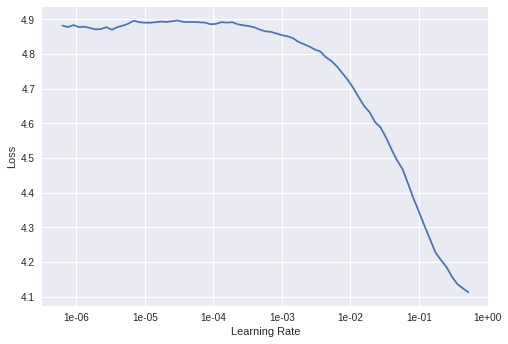

In [10]:
learn.recorder.plot(skip_end=15)


In [11]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.754852,2.243954,0.573148,00:34


In [12]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.217939,2.041765,0.600220,00:42
1,1.996509,1.854115,0.627469,00:42
2,1.789142,1.739858,0.643640,00:42
3,1.595984,1.672943,0.654883,00:42
4,1.429584,1.632417,0.662103,00:42
5,1.288205,1.620777,0.663724,00:42
6,1.173000,1.615937,0.666226,00:42
7,1.089465,1.619970,0.666347,00:42
8,1.042140,1.623362,0.666590,00:42
9,1.011007,1.623179,0.666964,00:42


In [0]:
learn.save_encoder('fine_tuned_enc')


## Classifier

In [0]:
data_clas = (TextList.from_csv(path,'texts.csv', cols='text', vocab=data_lm.vocab)
             #grab all the text files in path
             .split_from_df(col=2)
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_df(cols=0)
             #label them all with their folders
             .databunch(bs=bs))


In [0]:
data_clas.save('data_clas.pkl')

In [16]:
data_clas.show_batch()

text,target
"xxbos xxmaj xxunk xxup q1 for xxmaj ricoh . xxmaj japanese imaging and electronics vendor xxmaj ricoh has reported a xxunk xxup q1 . xxmaj for the quarter ended 30 xxmaj june 2018 , sales in its xxmaj office xxmaj services division increased 9.7 % to ¥ xxunk billion ( $ xxunk million ) compared to the same period last year . xxmaj sales were boosted by a xxunk %",2
"xxbos xxup at&t reports directv lost more satellite subscribers in xxup q2 , though directv xxmaj now continues to grow . xxup at&t ’s xxmaj entertainment xxmaj group segment , which includes the directv xxup u.s. video operations , fell 8 % in xxup q2 , to $ 11.7 billion — down by $ 1 billion from the year - earlier period . ( xxmaj on an adjusted basis ,",2
xxbos xxup ftc approves xxup dxc 's xxmaj molina xxmaj medicaid buy ; xxup dxc xxup uk cutting staff . xxmaj the xxmaj federal xxmaj trade xxmaj commission grants antitrust clearance for xxup dxc xxmaj technology ’s ( xxup dxc + 1.3 % ) purchase of xxmaj molina xxmaj medicaid xxmaj solutions from xxmaj molina xxmaj healthcare ( xxup xxunk ) . xxmaj the transaction was announced on xxmaj june,1
"xxbos xxmaj fine from the xxup xxunk to xxmaj xxunk , xxup ibm and nine more xxup it companies per xxunk in public procurement xxunk . xxmaj the xxmaj national xxmaj commission of xxmaj markets and xxmaj competition ( xxup xxunk ) has xxunk a xxunk of xxunk companies providing xxup it services to the xxmaj public xxmaj administration that was dedicated to divide the customers and agree prices and",2
"xxbos xxmaj google workers push tech giants to end forced arbitration . xxmaj in a sign of what 2019 may have in store for big tech , xxmaj google workers on xxmaj tuesday xxunk off a campaign demanding a complete end to the practice of forced arbitration . xxmaj forced arbitration , which was one focus of the massive xxmaj google xxmaj walkout in xxmaj november , xxunk means that",1


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


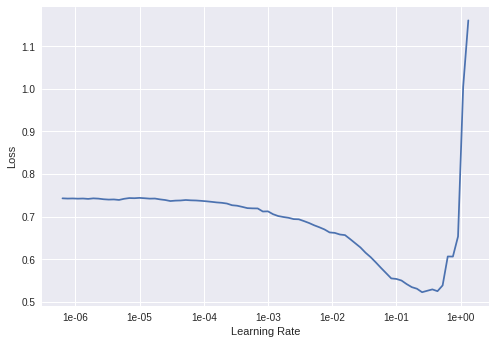

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.246200,0.142503,0.934737,00:20


In [21]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.168332,0.143612,0.934737,00:24


In [25]:
learn.predict("Google employees are so angry about how Google handled plans for a censored Chinese search engine, some are talking about a strike.Days after Google employees published an open letter calling for the company to cancel its controversial efforts to create a censored search engine in China, some employees are talking about creating a strike fund to support workers who decide to strike or resign in protest.")


(Category 2, tensor(1), tensor([0.0954, 0.9046]))

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

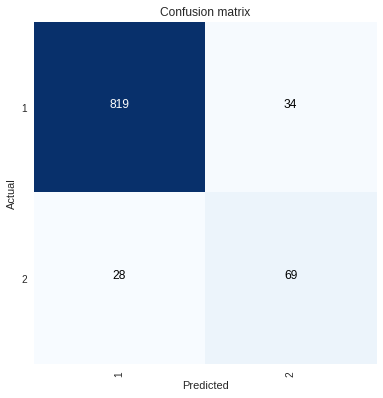

In [31]:
interp.plot_confusion_matrix()

In [30]:
interp.

(tensor([6.8337, 3.3797, 2.9112, 2.9086, 2.5103]),
 tensor([600, 898, 441,  48, 197]))